In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 11.4 MB/s eta 0:00:00


In [ ]:
#Import packages
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files
import io
from google.colab import drive

#Metrics/processing imports
from sklearn.model_selection import train_test_split
from sklearn import metrics
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from collections import Counter

#Model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#Neural net imports
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import tensorflow.keras.backend as k
from tensorflow.keras.optimizers import SGD

#Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#Shap values
import shap
from scipy.special import softmax

#Pickle
import pickle

In [ ]:
#Set seed
np.random.seed(1234)

In [ ]:
#Load data
drive.mount('/content/drive')
df =pd.read_csv("drive/My Drive/Capstone Project/Cervical_Cancer/kag_risk_factors_cervical_cancer.csv")
df.head()

Mounted at /content/drive


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [ ]:
df.describe()

,Age,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,0.087413,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,0.302545,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#Let's inspect the data
print(df.columns)

#Let's rename the columns so they are usable 
df.rename({
           'Age': 'age', 
           'Number of sexual partners': 'num_sex_partners',
           'First sexual intercourse': 'first_sex',
           'Num of pregnancies': 'num_preg',
           'Smokes': 'smoker',
           'Smokes (years)': 'smoke_years',
           'Smokes (packs/year)': 'pack_years',
           'Hormonal Contraceptives': 'contracept', 
           'Hormonal Contraceptives (years)': 'contracept_years',
           'IUD': 'iud',
           'IUD (years)': 'iud_years',
           'STDs': 'stds',
           'STDs (number)': 'stds_num',
           'STDs:condylomatosis': 'std_condy', 
           'STDs:cervical condylomatosis': 'std_cerv_condy',
           'STDs:vaginal condylomatosis': 'std_vag_condy',
           'STDs:vulvo-perineal condylomatosis': 'std_vulvperi_condy',
           'STDs:syphilis': 'std_syphilis',
           'STDs:pelvic inflammatory disease': 'std_pid',
           'STDs:genital herpes': 'std_herpes',
           'STDs:molluscum contagiosum': 'std_molluscum', 
           'STDs:AIDS': 'std_aids',
           'STDs:HIV': 'std_hiv',
           'STDs:Hepatitis B': 'std_hep_b',
           'STDs:HPV': 'std_hpv',
           'STDs: Number of diagnosis': 'std_num_dx',
           'STDs: Time since first diagnosis': 'std_time_first_dx',
           'STDs: Time since last diagnosis': 'std_time_last_dx',
           'Dx:Cancer': 'cancer', 
           'Dx:CIN': 'cin', 
           'Dx:HPV': 'hpv', 
           'Dx': 'dx', 
           'Hinselmann': 'hinselmann',
           'Schiller': 'schiller', 
           'Citology': 'cytology',
           'Biopsy': 'biopsy'
           }, 
          axis=1, 
          inplace=True)


Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')


In [ ]:
print(df.columns)

Index(['age', 'num_sex_partners', 'first_sex', 'num_preg', 'smoker',
       'smoke_years', 'pack_years', 'contracept', 'contracept_years', 'iud',
       'iud_years', 'stds', 'stds_num', 'std_condy', 'std_cerv_condy',
       'std_vag_condy', 'std_vulvperi_condy', 'std_syphilis', 'std_pid',
       'std_herpes', 'std_molluscum', 'std_aids', 'std_hiv', 'std_hep_b',
       'std_hpv', 'std_num_dx', 'std_time_first_dx', 'std_time_last_dx',
       'cancer', 'cin', 'hpv', 'dx', 'hinselmann', 'schiller', 'cytology',
       'biopsy'],
      dtype='object')


In [ ]:
df.shape  

(858, 36)

In [ ]:
#Describing numeric values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0
std_num_dx,858.0,0.087413,0.302545,0.0,0.0,0.0,0.0,3.0
cancer,858.0,0.020979,0.143398,0.0,0.0,0.0,0.0,1.0
cin,858.0,0.010490,0.101939,0.0,0.0,0.0,0.0,1.0
hpv,858.0,0.020979,0.143398,0.0,0.0,0.0,0.0,1.0
dx,858.0,0.027972,0.164989,0.0,0.0,0.0,0.0,1.0
hinselmann,858.0,0.040793,0.197925,0.0,0.0,0.0,0.0,1.0
schiller,858.0,0.086247,0.280892,0.0,0.0,0.0,0.0,1.0
cytology,858.0,0.051282,0.220701,0.0,0.0,0.0,0.0,1.0
biopsy,858.0,0.064103,0.245078,0.0,0.0,0.0,0.0,1.0


In [ ]:
#Describing categorical values
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,858.0,NaN,NaN,NaN,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0
num_sex_partners,858,13,2.0,272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_sex,858,22,15.0,163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_preg,858,12,1.0,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoker,858,3,0.0,722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoke_years,858,31,0.0,722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pack_years,858,63,0.0,722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contracept,858,3,1.0,481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contracept_years,858,41,0.0,269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iud,858,3,0.0,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Correlations
df.corr()

,age,std_num_dx,cancer,cin,hpv,dx,hinselmann,schiller,cytology,biopsy
age,1.000000,-0.001606,0.110340,0.061443,0.101722,0.092635,-0.003967,0.103283,-0.016862,0.055956
std_num_dx,-0.001606,1.000000,-0.015423,0.008070,-0.015423,-0.002289,0.076787,0.130873,0.055114,0.097449
cancer,0.110340,-0.015423,1.000000,-0.015072,0.886508,0.665647,0.134264,0.157812,0.113446,0.160905
cin,0.061443,0.008070,-0.015072,1.000000,-0.015072,0.606939,-0.021233,0.009119,-0.023938,0.113172
hpv,0.101722,-0.015423,0.886508,-0.015072,1.000000,0.616327,0.134264,0.157812,0.113446,0.160905
dx,0.092635,-0.002289,0.665647,0.606939,0.616327,1.000000,0.072215,0.098952,0.088740,0.157607
hinselmann,-0.003967,0.076787,0.134264,-0.021233,0.134264,0.072215,1.000000,0.650249,0.192467,0.547417
schiller,0.103283,0.130873,0.157812,0.009119,0.157812,0.098952,0.650249,1.000000,0.361486,0.733204
cytology,-0.016862,0.055114,0.113446,-0.023938,0.113446,0.088740,0.192467,0.361486,1.000000,0.327466
biopsy,0.055956,0.097449,0.160905,0.113172,0.160905,0.157607,0.547417,0.733204,0.327466,1.000000


In [ ]:
#Looks like some cells have "?" which is NA
#We have to convert these to NAs
df = df.replace('?', np.nan)

In [ ]:
#Looking at missing values
df.isnull().sum()

age                     0
num_sex_partners       26
first_sex               7
num_preg               56
smoker                 13
smoke_years            13
pack_years             13
contracept            108
contracept_years      108
iud                   117
iud_years             117
stds                  105
stds_num              105
std_condy             105
std_cerv_condy        105
std_vag_condy         105
std_vulvperi_condy    105
std_syphilis          105
std_pid               105
std_herpes            105
std_molluscum         105
std_aids              105
std_hiv               105
std_hep_b             105
std_hpv               105
std_num_dx              0
std_time_first_dx     787
std_time_last_dx      787
cancer                  0
cin                     0
hpv                     0
dx                      0
hinselmann              0
schiller                0
cytology                0
biopsy                  0
dtype: int64

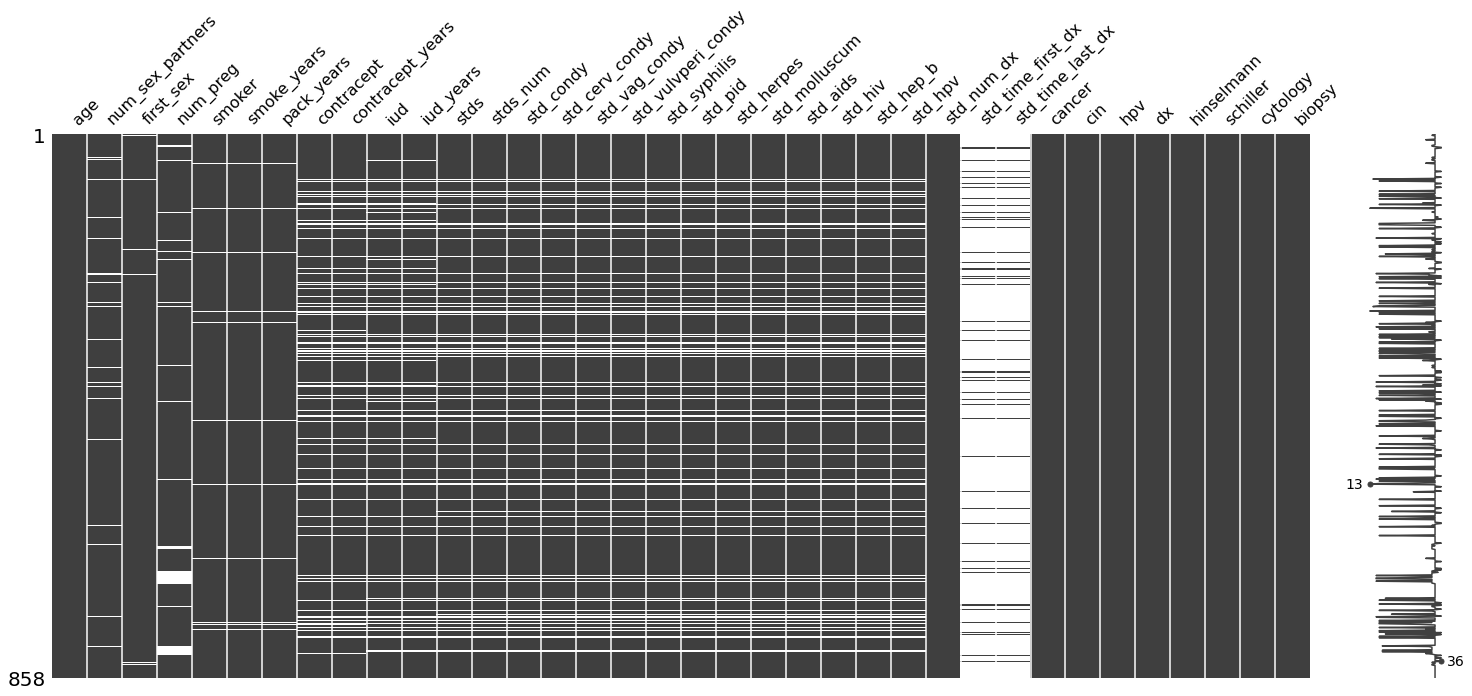

In [ ]:
#Visualize missing values
msno.matrix(df)

In [ ]:
#Two columns have 787 missing values, let's drop those
df.drop(['std_time_first_dx', 'std_time_last_dx'], axis=1, inplace = True)

In [ ]:
# fill pack_years and stds null vals with 0, not median
df[['pack_years','stds']] = df[['pack_years','stds']].fillna(0)

# fill other null values with median
df = df.fillna(df.median())
df.isnull().sum()
df.to_csv("cleaned.csv")

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


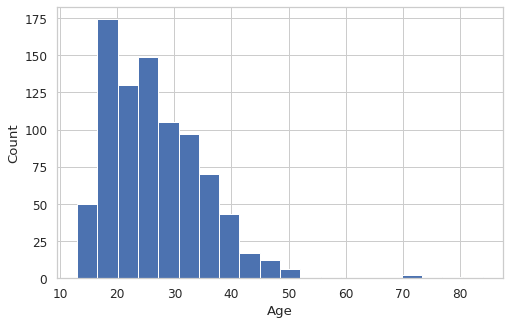

In [ ]:
#Create some visualizations
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    df['age'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='Age', ylabel='Count');

In [ ]:
print("The minimum age is:", df['age'].min())
print("Old df shape", df.shape)
#The minimum age is 13, we should get rid of anyone who is below 21

df = df.loc[df['age'] >= 21]
print("New df shape", df.shape)

The minimum age is: 13
Old df shape (858, 34)
New df shape (634, 34)


In [ ]:
df.value_counts('cancer')
#We have 617 non cancer and 17 cancer 

cancer
0    617
1     17
dtype: int64


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


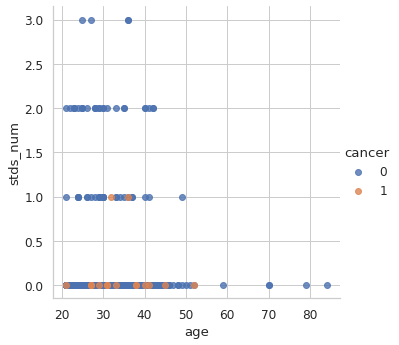

In [ ]:
#Some more visualizations
df['stds_num'] = df['stds_num'].astype(np.float16)

sns.lmplot(x = 'age', y = 'stds_num', data = df, fit_reg=False, hue = 'cancer')


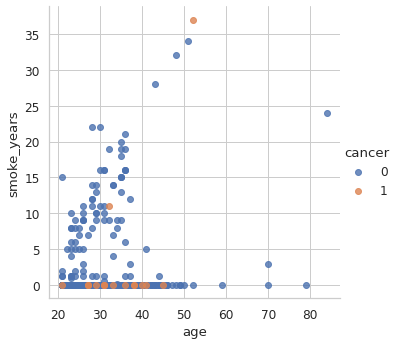

In [ ]:
df['smoke_years'] = df['smoke_years'].astype(np.float16)
sns.lmplot(x = 'age', y = 'smoke_years', data = df, fit_reg=False, hue = 'cancer')


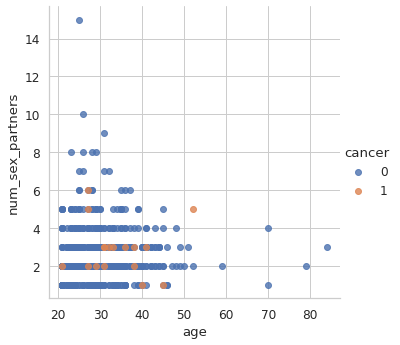

In [ ]:
df['num_sex_partners'] = df['num_sex_partners'].astype(np.float16)
sns.lmplot(x = 'age', y = 'num_sex_partners', data = df, fit_reg=False, hue = 'cancer')


In [ ]:
#Converting them all to floats
df = df.astype(np.float16)

In [ ]:
for v in df.columns:
    print(df[v].value_counts())

23.0    54
21.0    46
24.0    39
25.0    39
26.0    38
28.0    37
30.0    35
29.0    33
27.0    33
22.0    30
35.0    29
33.0    28
31.0    27
36.0    24
34.0    24
32.0    18
37.0    17
41.0    13
40.0    12
38.0     9
39.0     9
44.0     6
45.0     6
42.0     6
43.0     5
46.0     3
48.0     2
70.0     2
49.0     2
52.0     2
59.0     1
79.0     1
84.0     1
47.0     1
50.0     1
51.0     1
Name: age, dtype: int64
2.0     219
3.0     169
1.0     128
4.0      61
5.0      37
6.0       9
7.0       4
8.0       4
15.0      1
10.0      1
9.0       1
Name: num_sex_partners, dtype: int64
17.0    132
18.0    119
15.0     95
16.0     78
19.0     57
20.0     36
14.0     29
21.0     20
13.0     15
23.0      9
22.0      9
26.0      7
27.0      6
24.0      6
29.0      5
12.0      3
28.0      3
25.0      2
32.0      1
11.0      1
10.0      1
Name: first_sex, dtype: int64
2.0     221
3.0     134
1.0     132
4.0      70
5.0      35
6.0      18
0.0      14
7.0       6
8.0       2
11.0      1
10.0     

In [ ]:
#df.columns

#Drop: std_cerv_condy, std_vag_condy, std_pid, std_herpes, std_molluscum, std_aids, std_hep_b, std_hpv due to lack of observations

df.drop('std_cerv_condy', axis = 1, inplace = True)
df.drop('std_vag_condy', axis = 1, inplace = True)
df.drop('std_pid', axis = 1, inplace = True)
df.drop('std_herpes', axis = 1, inplace = True)
df.drop('std_molluscum', axis = 1, inplace = True)
df.drop('std_aids', axis = 1, inplace = True)
df.drop('std_hep_b', axis = 1, inplace = True)
df.drop('std_hpv', axis = 1, inplace = True)

In [ ]:
#The columns about how the sample was obtained are useless
#Dropping hinselmann, schiller, cytology, biopsy

df.drop('hinselmann', axis = 1, inplace = True)
df.drop('schiller', axis = 1, inplace = True)
df.drop('cytology', axis = 1, inplace = True)
df.drop('biopsy', axis = 1, inplace = True)

In [ ]:
#The hpv variable is the exact same as the cancer variable
df.drop('hpv', axis = 1, inplace = True)

#I looked online and no one could define what the dx variable was so we're getting rid of it 
df.drop('dx', axis = 1, inplace = True)


In [ ]:
#Let's build a baseline decision tree model

#Get labels as an array and not as an array 
labels = np.array(df['cancer'])
columns_labels = df['cancer']

#Drop cancer variable (and HPV variable)
df.drop('cancer', axis = 1, inplace = True)
df_list = list(df.columns)

#Create dummies/one hot encoding
df_dum = pd.get_dummies(df)
df_list_dum = list(df_dum.columns)

In [ ]:
# Split the data into training and testing sets
train_df, test_df, train_labels, test_labels = train_test_split(df_dum, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_df.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_df.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (475, 19)
Training Labels Shape: (475,)
Testing Features Shape: (159, 19)
Testing Labels Shape: (159,)


In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_df, train_labels)

y_pred=rf.predict(test_df)


In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Test Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Test Accuracy: 0.9811320754716981


In [ ]:
feature_imp = pd.Series(rf.feature_importances_,index=df_dum.columns).sort_values(ascending=False)
feature_imp

age                   0.186091
contracept_years      0.176154
first_sex             0.154102
num_sex_partners      0.117749
num_preg              0.098539
iud_years             0.070197
pack_years            0.043511
smoke_years           0.043052
contracept            0.023575
iud                   0.021491
stds_num              0.017794
stds                  0.012771
std_num_dx            0.010220
smoker                0.007831
std_condy             0.006457
std_vulvperi_condy    0.004793
std_hiv               0.003064
std_syphilis          0.001991
cin                   0.000617
dtype: float64

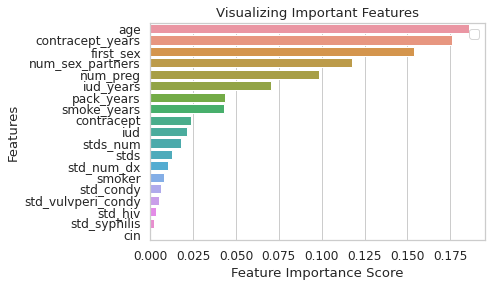

In [ ]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
#This all makes sense
#We could drop least important features: cin, std_syphilis, std_hiv, std_condy, std_vulvperi_condy
#Let's get a more parsimonius baseline mode
df.drop('cin', axis = 1, inplace = True)
df.drop('std_syphilis', axis = 1, inplace = True)
df.drop('std_hiv', axis = 1, inplace = True)
df.drop('std_condy', axis = 1, inplace = True)
df.drop('std_vulvperi_condy', axis = 1, inplace = True)

#Create dummies/one hot encoding
df_dum = pd.get_dummies(df)
df_list_dum = list(df_dum.columns)

# Split the data into training and testing sets
train_df, test_df, train_labels, test_labels = train_test_split(df_dum, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_df.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_df.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (475, 14)
Training Labels Shape: (475,)
Testing Features Shape: (159, 14)
Testing Labels Shape: (159,)


In [ ]:
# Train the model on training data
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

rf.fit(train_df, train_labels)

y_pred=rf.predict(test_df)
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.9811320754716981


In [ ]:
feature_imp = pd.Series(rf.feature_importances_,index=df_dum.columns).sort_values(ascending=False)
feature_imp

age                 0.187704
contracept_years    0.176647
first_sex           0.158491
num_sex_partners    0.114913
num_preg            0.103606
iud_years           0.071381
pack_years          0.042708
smoke_years         0.042602
contracept          0.026038
iud                 0.023577
stds_num            0.019641
stds                0.014434
std_num_dx          0.009629
smoker              0.008629
dtype: float64

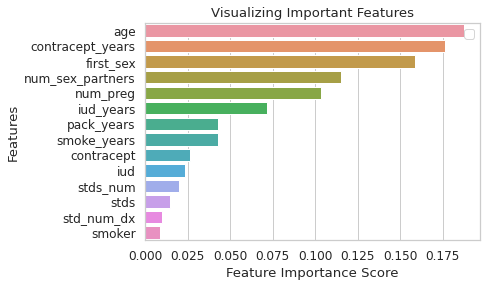

In [ ]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
print(df['std_num_dx'].value_counts())
print(df['stds'].value_counts())

0.0    582
1.0     52
Name: std_num_dx, dtype: int64
0.0    575
1.0     59
Name: stds, dtype: int64


In [ ]:
#Dropping additional features per convo with Julia
df.drop('contracept', axis = 1, inplace = True)
df.drop('iud', axis = 1, inplace = True)
df.drop('std_num_dx', axis = 1, inplace = True)
df.drop('stds', axis = 1, inplace = True)
df.drop('smoker', axis = 1, inplace = True)
df.drop('smoke_years', axis = 1, inplace = True)

#These are the final variables to keep
#Age
#Contracept_years - # years on contraception
#First_sex - age first intercourse
#Num_sex_partners
#Num_preg
#Iud_years - # years with IUD
#Pack_years
#Stds - number of STD diagnoses


In [ ]:
#Now let's try to expand the dataset with smote 
#Synthetic minority oversampling technique
#Used when there is imbalanced classification, i.e. too few examples of the minority class 
#We can oversample the examples in the minority class 
#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

#An improvement on duplicating examples from the minority class is to synthesize 
#new examples from the minority class. This is a type of data augmentation for tabular 
#data and can be very effective.
#SMOTE works by selecting examples that are close in the feature space, drawing a line
#between the examples in the feature space and drawing a new sample at a point along that line.

# Transform the dataset
oversample = SMOTE() #Completely balance
df, columns_labels = oversample.fit_resample(df, columns_labels)

counter = Counter(columns_labels)
print(counter)

#Awesome, we have more observations now !

Counter({0.0: 617, 1.0: 617})


In [ ]:
df = pd.concat([df, columns_labels], axis=1)

In [ ]:
df.head()

,age,num_sex_partners,first_sex,num_preg,pack_years,contracept_years,iud_years,stds_num,cancer
0,34.0,1.0,17.0,1.0,0.000000,0.0,0.0,0.0,0.0
1,52.0,5.0,16.0,4.0,37.000000,3.0,0.0,0.0,1.0
2,46.0,3.0,21.0,4.0,0.000000,15.0,0.0,0.0,0.0
3,42.0,3.0,23.0,2.0,0.000000,0.0,0.0,0.0,0.0
4,51.0,3.0,17.0,6.0,3.400391,0.0,7.0,0.0,0.0


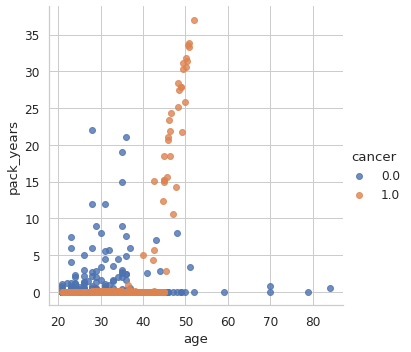

In [ ]:
#Let's go back to our EDA, and combine the dataframe 

sns.lmplot(x = 'age', y = 'pack_years', data = df, fit_reg=False, hue = 'cancer')

In [ ]:
#Now let's try the random forest with the new dataset 
#Create labels
labels = np.array(df['cancer'])
df.drop('cancer', axis = 1, inplace = True)

#Create dummies/one hot encoding
df_dum = pd.get_dummies(df)
df_list_dum = list(df_dum.columns)

# Split the data into training and testing sets
train_df, test_df, train_labels, test_labels = train_test_split(df_dum, labels, test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_df.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_df.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (925, 8)
Training Labels Shape: (925,)
Testing Features Shape: (309, 8)
Testing Labels Shape: (309,)


In [ ]:
# Train the model on training data
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

rf_model = rf.fit(train_df, train_labels)

pred_train = rf_model.predict(train_df)
pred_test = rf_model.predict(test_df)

print("Accuracy train: ", metrics.accuracy_score(train_labels, pred_train))
print("Accuracy test: ", metrics.accuracy_score(test_labels, pred_test))

Accuracy train:  1.0
Accuracy test:  0.9902912621359223


In [ ]:
feature_imp = pd.Series(rf.feature_importances_,index=df_dum.columns).sort_values(ascending=False)
feature_imp

first_sex           0.261813
age                 0.154283
num_preg            0.136172
num_sex_partners    0.132834
iud_years           0.124037
contracept_years    0.115064
stds_num            0.052130
pack_years          0.023666
dtype: float64

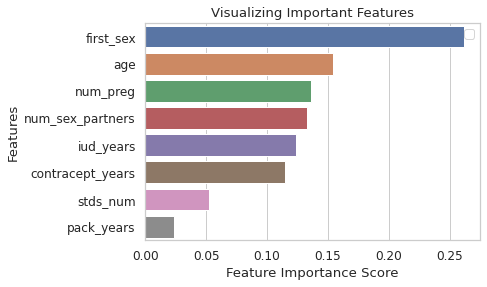

In [ ]:
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

[[163   0]
 [  3 143]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


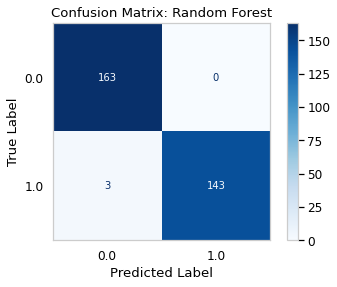

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       163
         1.0       1.00      0.98      0.99       146

    accuracy                           0.99       309
   macro avg       0.99      0.99      0.99       309
weighted avg       0.99      0.99      0.99       309



In [ ]:
#Confusion matrix

print(confusion_matrix(test_labels, pred_test))
color='black'
matrix = plot_confusion_matrix(rf, test_df, test_labels, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix: Random Forest', color=color)
plt.grid(b=None)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

#Classification report 
print(classification_report(test_labels, pred_test))

In [ ]:
#Getting metrics 
y_pred_rf = rf.predict(test_df)
train_pred_rf = rf.predict(train_df)
print("Train Accuracy:",metrics.accuracy_score(train_labels, train_pred_rf))
print("Test Accuracy:",metrics.accuracy_score(test_labels, y_pred_rf))
print("Precision:",metrics.precision_score(test_labels, y_pred_rf))
print("Recall:",metrics.recall_score(test_labels, y_pred_rf))

#Justification for not using this model? 

Train Accuracy: 1.0
Test Accuracy: 0.9902912621359223
Precision: 1.0
Recall: 0.9794520547945206


Train Accuracy: 0.9837837837837838
Test Accuracy: 0.9546925566343042
Precision: 0.9459459459459459
Recall: 0.958904109589041
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96       163
         1.0       0.95      0.96      0.95       146

    accuracy                           0.95       309
   macro avg       0.95      0.95      0.95       309
weighted avg       0.95      0.95      0.95       309

[[155   8]
 [  6 140]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


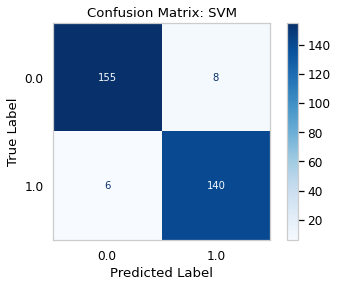

In [ ]:
#SVM
svm_clf = svm.SVC(kernel = 'rbf', gamma = 0.1)
svm_clf.fit(train_df, train_labels)
y_pred_svm = svm_clf.predict(test_df)
train_pred_svm = svm_clf.predict(train_df)
print("Train Accuracy:",metrics.accuracy_score(train_labels, train_pred_svm))
print("Test Accuracy:",metrics.accuracy_score(test_labels, y_pred_svm))
print("Precision:",metrics.precision_score(test_labels, y_pred_svm))
print("Recall:",metrics.recall_score(test_labels, y_pred_svm))

#Classification report SVM 
print(classification_report(test_labels, y_pred_svm))

#Confusion matrix
print(confusion_matrix(test_labels, y_pred_svm))
color='black'
matrix = plot_confusion_matrix(svm_clf, test_df, test_labels, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix: SVM', color=color)
plt.grid(b=None)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

Train Accuracy: 0.9589189189189189
Test Accuracy: 0.9158576051779935
Precision: 0.8614457831325302
Recall: 0.9794520547945206
              precision    recall  f1-score   support

         0.0       0.98      0.86      0.92       163
         1.0       0.86      0.98      0.92       146

    accuracy                           0.92       309
   macro avg       0.92      0.92      0.92       309
weighted avg       0.92      0.92      0.92       309

[[140  23]
 [  3 143]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


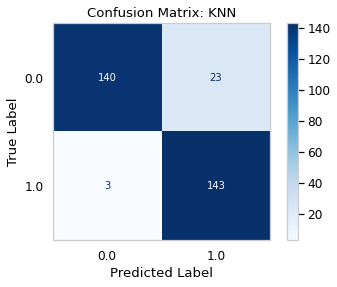

In [ ]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_df, train_labels)
y_pred_knn = knn.predict(test_df)
train_pred_knn = knn.predict(train_df)
print("Train Accuracy:",metrics.accuracy_score(train_labels, train_pred_knn))
print("Test Accuracy:",metrics.accuracy_score(test_labels, y_pred_knn))
print("Precision:",metrics.precision_score(test_labels, y_pred_knn))
print("Recall:",metrics.recall_score(test_labels, y_pred_knn))

#Classification report KNN 
print(classification_report(test_labels, y_pred_knn))

#Confusion matrix
print(confusion_matrix(test_labels, y_pred_knn))
color='black'
matrix = plot_confusion_matrix(knn, test_df, test_labels, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix: KNN', color=color)
plt.grid(b=None)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

Train Accuracy: 0.7156756756756757
Test Accuracy: 0.7637540453074434
Precision: 0.7482993197278912
Recall: 0.7534246575342466
              precision    recall  f1-score   support

         0.0       0.78      0.77      0.78       163
         1.0       0.75      0.75      0.75       146

    accuracy                           0.76       309
   macro avg       0.76      0.76      0.76       309
weighted avg       0.76      0.76      0.76       309

[[126  37]
 [ 36 110]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


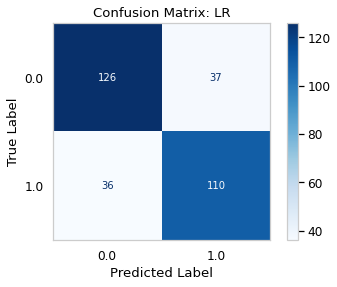

In [ ]:
#Logistic Regression
lr = LogisticRegression(penalty = 'l2')
lr.fit(train_df, train_labels)
y_pred_lr = lr.predict(test_df)
train_pred_lr = lr.predict(train_df)
print("Train Accuracy:",metrics.accuracy_score(train_labels, train_pred_lr))
print("Test Accuracy:",metrics.accuracy_score(test_labels, y_pred_lr))
print("Precision:",metrics.precision_score(test_labels, y_pred_lr))
print("Recall:",metrics.recall_score(test_labels, y_pred_lr))

#Classification report SVM 
print(classification_report(test_labels, y_pred_lr))

#Confusion matrix
print(confusion_matrix(test_labels, y_pred_lr))
color='black'
matrix = plot_confusion_matrix(lr, test_df, test_labels, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix: LR', color=color)
plt.grid(b=None)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
#Neural network - simple MLP 
nn_model = Sequential([
    Dense(input_shape=[8], units=32, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Dense(units=16, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    Dense(name = "output_layer", units = 1, activation = tf.nn.sigmoid)
])

In [ ]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 output_layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn_model.compile(optimizer='adam',           
               loss = 'binary_crossentropy',
               metrics=['accuracy'])
#There are many optimizers to use -- also part of hyperparameter tuning

In [ ]:
tf.config.run_functions_eagerly(True)

nn_history = nn_model.fit(
    train_df
    ,train_labels
    ,epochs = 100
    ,batch_size = 20
    ,validation_split=0.20 
    ,callbacks=[tf.keras.callbacks.ModelCheckpoint("Risk_model_1.h5",save_best_only=True,save_weights_only=False)
                ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
    )
#The callbacks is a checkpoint to save the model object as a pretrained model so you can use it
#Early stopping will stop training when the monitor value (val_accuracy) fails to improve over
#the last couple of epochs 
#Training will terminate early with early stopping--prevents overfitting

Epoch 1/100


Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.


36/37 [============================>.] - ETA: 0s - loss: 0.7790 - accuracy: 0.5417

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.


37/37 [==============================] - 3s 87ms/step - loss: 0.7755 - accuracy: 0.5419 - val_loss: 0.6871 - val_accuracy: 0.5135
Epoch 2/100
37/37 [==============================] - 1s 39ms/step - loss: 0.6697 - accuracy: 0.5743 - val_loss: 0.6301 - val_accuracy: 0.6162
Epoch 3/100
37/37 [==============================] - 1s 39ms/step - loss: 0.6482 - accuracy: 0.6243 - val_loss: 0.5973 - val_accuracy: 0.7568
Epoch 4/100
37/37 [==============================] - 2s 44ms/step - loss: 0.5946 - accuracy: 0.7027 - val_loss: 0.5399 - val_accuracy: 0.7892
Epoch 5/100
37/37 [==============================] - 2s 51ms/step - loss: 0.5732 - accuracy: 0.7243 - val_loss: 0.5482 - val_accuracy: 0.6811
Epoch 6/100
37/37 [==============================] - 2s 53ms/step - loss: 0.5606 - accuracy: 0.7149 - val_loss: 0.5265 - val_accuracy: 0.7676


In [ ]:
#Test accuracy
print(f"Test acc: {nn_model.evaluate(test_df, test_labels)[1]:.3f}")

10/10 [==============================] - 0s 13ms/step - loss: 0.5052 - accuracy: 0.8058
Test acc: 0.806


Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.


Train Accuracy: 0.9967567567567568
Test Accuracy: 0.9644012944983819
Precision: 0.9470198675496688
Recall: 0.9794520547945206
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97       163
         1.0       0.95      0.98      0.96       146

    accuracy                           0.96       309
   macro avg       0.96      0.97      0.96       309
weighted avg       0.96      0.96      0.96       309

[[155   8]
 [  3 143]]


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


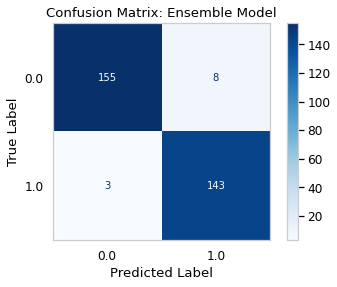

In [ ]:
#Ensemble model - max voting classifier

#We will use RF, KNN, SVM, LR

lr_ensemble = LogisticRegression(penalty = 'l2')
svm_ensemble = svm.SVC(kernel = 'rbf', gamma = 0.1,probability=True)
knn_ensemble = KNeighborsClassifier(n_neighbors=3)
rf_ensemble = RandomForestClassifier(n_estimators = 1000, random_state = 42)

ensemble_model = VotingClassifier(
    estimators=[('lr', lr_ensemble), ('svm', svm_ensemble), ('rf', rf_ensemble), ('knn', knn_ensemble)], voting='soft')

ensemble_model.fit(train_df, train_labels)
pred_ensemble = ensemble_model.predict(test_df)
train_pred_ensemble = ensemble_model.predict(train_df)
print("Train Accuracy:",metrics.accuracy_score(train_labels, train_pred_ensemble))
print("Test Accuracy:",metrics.accuracy_score(test_labels, pred_ensemble))
print("Precision:",metrics.precision_score(test_labels, pred_ensemble))
print("Recall:",metrics.recall_score(test_labels, pred_ensemble))

#Classification report 
print(classification_report(test_labels, pred_ensemble))

#Confusion matrix
print(confusion_matrix(test_labels, pred_ensemble))
color='black'
matrix = plot_confusion_matrix(ensemble_model, test_df, test_labels, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix: Ensemble Model', color=color)
plt.grid(b=None)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [ ]:
#Saving this model 

filename = 'final_risk_model.pkl'

with open(filename, 'wb') as file:  
    pickle.dump(ensemble_model, file)

# some time later...
 
# load the model from disk
#with open(filename, 'rb') as file:  
#    ensemble_model = pickle.load(file)

#ensemble_model
#result = loaded_model.score(test_df, test_labels)
#print(result)

# Load the Model back from file


In [ ]:
#Shap values for the ensemble model (can do this for our final model of choice)
# Fits the explainer
explainer = shap.Explainer(ensemble_model.predict, test_df)
# Calculates the SHAP values - It takes some time
shap_values = explainer(test_df)



Compilation is falling back to object mode WITH looplifting enabled because Function "_delta_masking" failed type inference due to: Invalid use of type(CPUDispatcher(<function _single_delta_mask at 0x7f2aa959b8b0>)) with parameters (int64, array(float16, 2d, C), array(bool, 1d, C), array(float16, 2d, C), array(float16, 1d, A), int64)

During: resolving callee type: type(CPUDispatcher(<function _single_delta_mask at 0x7f2aa959b8b0>))
During: typing of call at /usr/local/lib/python3.8/dist-packages/shap/maskers/_tabular.py (217)


File "../usr/local/lib/python3.8/dist-packages/shap/maskers/_tabular.py", line 217:
def _delta_masking(masks, x, curr_delta_inds, varying_rows_out,
    <source elided>
            curr_delta_inds[dpos] = -curr_delta_inds[dpos] - 1 # -value + 1 is the original index that needs flipped
            _single_delta_mask(curr_delta_inds[dpos], masked_inputs_tmp, last_mask, data, x, noop_code)
            ^

Function "_delta_masking" was compiled in object mode withou

In [ ]:
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [ ]:
print_feature_importances_shap_values(shap_values, df.columns)

iud_years -> 0.1463 (softmax = 0.1340)
age -> 0.1210 (softmax = 0.1307)
first_sex -> 0.1188 (softmax = 0.1304)
contracept_years -> 0.0767 (softmax = 0.1250)
num_preg -> 0.0507 (softmax = 0.1218)
num_sex_partners -> 0.0488 (softmax = 0.1216)
pack_years -> 0.0316 (softmax = 0.1195)
stds_num -> 0.0103 (softmax = 0.1170)


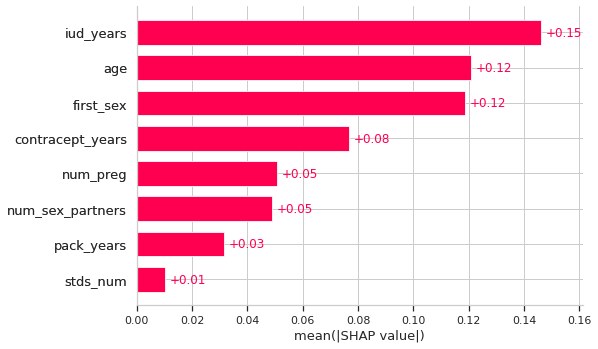

In [ ]:
shap.plots.bar(shap_values)

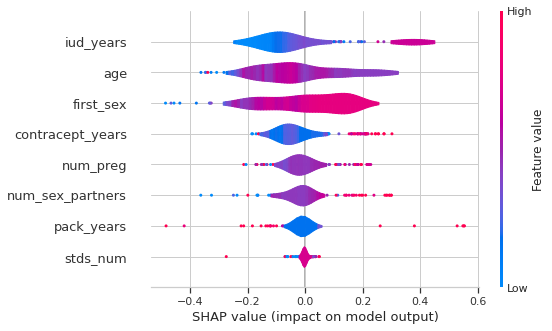

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

In [ ]:
df.columns

Index(['age', 'num_sex_partners', 'first_sex', 'num_preg', 'pack_years',
       'contracept_years', 'iud_years', 'stds_num'],
      dtype='object')

In [ ]:
prediction_prob = ensemble_model.predict_proba(pd.DataFrame([[25, 1, 20, 1, 10, 10, 10, 1]]))

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [ ]:
prediction_prob[:,1]


array([0.29172091])

In [ ]:
ensemble_model.classes_

array([0., 1.], dtype=float16)

In [ ]:
# Define the prediction function
import warnings
warnings.filterwarnings("ignore")
def predict(model, age,num_sex_partners,first_sex,num_preg,pack_years,contracept_years,iud_years,stds_num):
    #Predicting the price of the carat
    prediction_prob = model.predict_proba(pd.DataFrame([[age,num_sex_partners,first_sex,num_preg,pack_years,contracept_years,iud_years,stds_num]]))
    risk_array = prediction_prob[:, 1]
    risk = risk_array.astype(float)
    if risk < 0.25:
        print('Low Risk')
    elif (0.25 <= risk < 0.5):
        print('Low Moderate Risk')
    elif (0.5 <= risk < 0.75):
        print('High Moderate Risk')
    else:
        print('High Risk')




In [ ]:
predict(ensemble_model, 25, 1, 20, 1, 10, 10, 10, 1)


Low Moderate Risk


In [ ]:
# Define the prediction function
import warnings
warnings.filterwarnings("ignore")
def predict(model, age,num_sex_partners,first_sex,num_preg,pack_years,contracept_years,iud_years,stds_num):
    #Predicting the price of the carat
    prediction_prob = model.predict_proba(pd.DataFrame([[age,num_sex_partners,first_sex,num_preg,pack_years,contracept_years,iud_years,stds_num]]))
    risk_array = prediction_prob[:, 1]
    risk = risk_array.astype(float)
    if risk < 0.25:
        category = 'Low Risk'
    elif (0.25 <= risk < 0.5):
        category = 'Low Moderate Risk'
    elif (0.5 <= risk < 0.75):
        category = 'High Moderate Risk'
    else:
        category = 'High Risk'
    return category 

In [ ]:
category = predict(ensemble_model, 25, 1, 20, 1, 10, 10, 10, 1)
category
print('Your risk category is {}'.format(category))

Your risk category is Low Moderate Risk
